Neural-Twin initializing on: cpu
Material Physics -> Lambda: 576.92, Mu: 384.62

[INFO] Starting SciML Training...
Epoch: 0 | Total Loss: 8150.01416 | Physics Residual: 8140.44287
Epoch: 200 | Total Loss: 0.83101 | Physics Residual: 0.71091
Epoch: 400 | Total Loss: 0.32532 | Physics Residual: 0.28207
Epoch: 600 | Total Loss: 0.16225 | Physics Residual: 0.14858
Epoch: 800 | Total Loss: 0.09687 | Physics Residual: 0.09106
Epoch: 1000 | Total Loss: 0.06689 | Physics Residual: 0.06260
Epoch: 1200 | Total Loss: 0.05012 | Physics Residual: 0.04630
Epoch: 1400 | Total Loss: 0.04062 | Physics Residual: 0.03706
Epoch: 1600 | Total Loss: 0.03301 | Physics Residual: 0.02995
Epoch: 1800 | Total Loss: 0.02795 | Physics Residual: 0.02529
[INFO] Training Completed in 198.50s


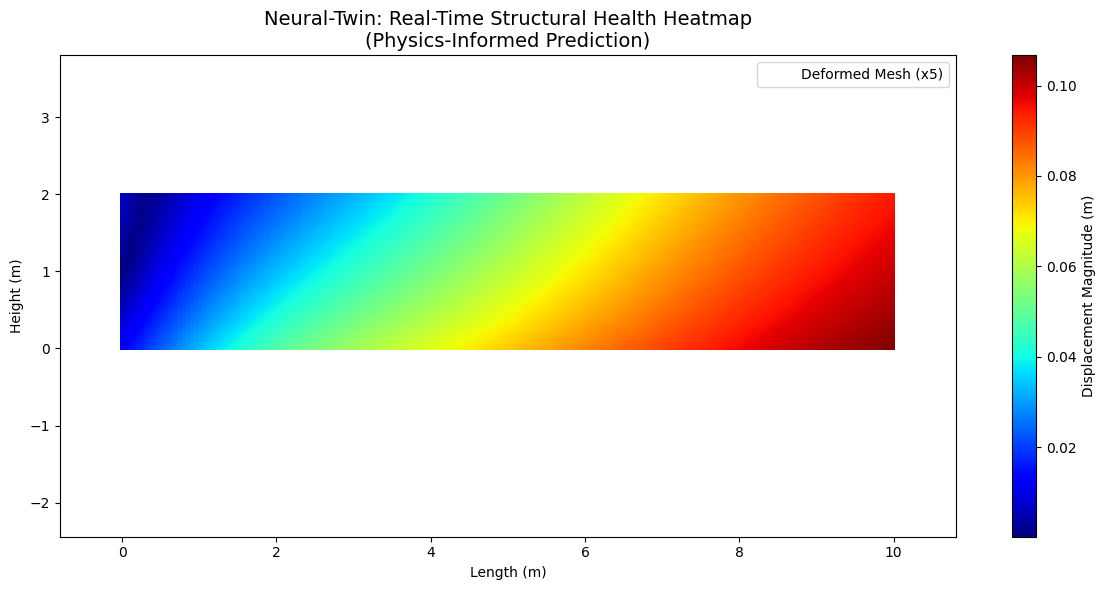

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time

# ==========================================
# 1. SETUP & CONFIGURATION
# ==========================================
# Set random seeds for reproducibility
torch.manual_seed(1234)
np.random.seed(1234)

# CUDA support if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Neural-Twin initializing on: {device}")

# Domain Bounds (2D Cantilever Beam)
L = 10.0  # Length
H = 2.0   # Height

# Material Properties (Normalized)
E = 1000.0  # Young's Modulus
nu = 0.3    # Poisson's Ratio

# Lamé Parameters (derived from E and nu for Navier-Cauchy equations)
lambda_ = (E * nu) / ((1 + nu) * (1 - 2 * nu))
mu = E / (2 * (1 + nu))

print(f"Material Physics -> Lambda: {lambda_:.2f}, Mu: {mu:.2f}")

# ==========================================
# 2. PHYSICS-INFORMED NEURAL NETWORK (PINN)
# ==========================================
class PhysicsInformedNN(nn.Module):
    def __init__(self, layers):
        super(PhysicsInformedNN, self).__init__()
        self.hidden_layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.hidden_layers.append(nn.Linear(layers[i], layers[i+1]))
        
        # Xavier Initialization for better convergence
        for layer in self.hidden_layers:
            nn.init.xavier_normal_(layer.weight)
            nn.init.zeros_(layer.bias)

    def forward(self, x):
        # Tanh activation is differentiable everywhere (crucial for physics derivatives)
        for i in range(len(self.hidden_layers) - 1):
            x = torch.tanh(self.hidden_layers[i](x))
        output = self.hidden_layers[-1](x)
        return output

# ==========================================
# 3. PHYSICS LOSS (NAVIER-CAUCHY EQUATIONS)
# ==========================================
def physics_loss(model, x_collocation):
    x_collocation.requires_grad = True
    
    # Predict Displacements (u, v)
    prediction = model(x_collocation)
    u = prediction[:, 0:1]
    v = prediction[:, 1:2]

    # Compute Spatial Gradients (Strains) using Automatic Differentiation
    u_grads = torch.autograd.grad(u, x_collocation, torch.ones_like(u), create_graph=True)[0]
    v_grads = torch.autograd.grad(v, x_collocation, torch.ones_like(v), create_graph=True)[0]
    
    u_x, u_y = u_grads[:, 0:1], u_grads[:, 1:2]
    v_x, v_y = v_grads[:, 0:1], v_grads[:, 1:2]

    # Constitutive Relations (Hooke's Law for Plane Stress)
    sigma_xx = (lambda_ + 2*mu) * u_x + lambda_ * v_y
    sigma_yy = (lambda_ + 2*mu) * v_y + lambda_ * u_x
    sigma_xy = mu * (u_y + v_x)

    # Compute Divergence of Stress (Equilibrium Equations)
    sxx_grads = torch.autograd.grad(sigma_xx, x_collocation, torch.ones_like(sigma_xx), create_graph=True)[0]
    sxy_grads = torch.autograd.grad(sigma_xy, x_collocation, torch.ones_like(sigma_xy), create_graph=True)[0]
    syy_grads = torch.autograd.grad(sigma_yy, x_collocation, torch.ones_like(sigma_yy), create_graph=True)[0]

    sxx_x = sxx_grads[:, 0:1]
    sxy_x, sxy_y = sxy_grads[:, 0:1], sxy_grads[:, 1:2]
    syy_y = syy_grads[:, 1:2]

    # Momentum Balance Residuals (Force Balance: f_x = 0, f_y = 0)
    momentum_x = sxx_x + sxy_y
    momentum_y = sxy_x + syy_y

    # Return Mean Squared Error of the residuals
    return torch.mean(momentum_x**2) + torch.mean(momentum_y**2)

# ==========================================
# 4. DATA GENERATION & TRAINING
# ==========================================
# A. Collocation Points (Random points inside the beam to enforce physics)
N_f = 2000 
X_f = np.random.rand(N_f, 2) * [L, H]
X_f = torch.tensor(X_f, dtype=torch.float32).to(device)

# B. Boundary Conditions (Fixed Support at x=0)
N_b = 100
y_b = np.random.uniform(0, H, (N_b, 1))
x_b = np.zeros((N_b, 1))
X_b_fixed = torch.tensor(np.hstack((x_b, y_b)), dtype=torch.float32).to(device)
u_b_fixed = torch.zeros((N_b, 2), dtype=torch.float32).to(device) # u=0, v=0

# C. Sparse Sensor Data (Simulating a downward bend at the tip x=L)
x_tip = np.full((20, 1), L)
y_tip = np.random.uniform(0, H, (20, 1))
X_sensor = torch.tensor(np.hstack((x_tip, y_tip)), dtype=torch.float32).to(device)

# Synthetic Sensor Readings (Parabolic downward deflection)
sensor_vals_v = -0.1 * (X_sensor[:, 0:1] / L)**2 
sensor_vals_u = torch.zeros_like(sensor_vals_v)
Y_sensor = torch.cat([sensor_vals_u, sensor_vals_v], dim=1).to(device)

# Initialize Model
layers = [2, 40, 40, 40, 40, 40, 40, 2] # Deep network
model = PhysicsInformedNN(layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training Loop
epochs = 2000
print("\n[INFO] Starting SciML Training...")
start_time = time.time()

for epoch in range(epochs):
    optimizer.zero_grad()
    
    # Calculate Losses
    loss_pde = physics_loss(model, X_f)              # Physics
    pred_fixed = model(X_b_fixed)
    loss_bc = torch.mean((pred_fixed - u_b_fixed)**2) # Fixed Support
    pred_sensor = model(X_sensor)
    loss_data = torch.mean((pred_sensor - Y_sensor)**2) # Sensor Data
    
    # Weighted Sum
    loss = loss_pde + 100*loss_bc + 100*loss_data
    
    loss.backward()
    optimizer.step()
    
    if epoch % 200 == 0:
        print(f'Epoch: {epoch} | Total Loss: {loss.item():.5f} | Physics Residual: {loss_pde.item():.5f}')

print(f"[INFO] Training Completed in {time.time() - start_time:.2f}s")

# ==========================================
# 5. VISUALIZATION (DIGITAL TWIN DASHBOARD)
# ==========================================
# Create a dense grid for high-res visualization
x_plot = np.linspace(0, L, 200)
y_plot = np.linspace(0, H, 50)
X, Y = np.meshgrid(x_plot, y_plot)
X_grid = np.vstack([X.flatten(), Y.flatten()]).T
X_grid_torch = torch.tensor(X_grid, dtype=torch.float32).to(device)

# Predict full field
with torch.no_grad():
    pred = model(X_grid_torch)
    u_pred = pred[:, 0].cpu().numpy().reshape(X.shape)
    v_pred = pred[:, 1].cpu().numpy().reshape(X.shape)
    displacement_mag = np.sqrt(u_pred**2 + v_pred**2)

# Plot Heatmap
plt.figure(figsize=(12, 6))
plt.title(f"Neural-Twin: Real-Time Structural Health Heatmap\n(Physics-Informed Prediction)", fontsize=14)
plt.pcolormesh(X, Y, displacement_mag, cmap='jet', shading='auto')
plt.colorbar(label='Displacement Magnitude (m)')
plt.xlabel('Length (m)')
plt.ylabel('Height (m)')
plt.axis('equal')

# Overlay Deformed Shape (Exaggerated)
scale = 5.0
plt.scatter((X + u_pred*scale)[::200], (Y + v_pred*scale)[::200], s=1, c='white', alpha=0.5, label='Deformed Mesh (x5)')
plt.legend()
plt.tight_layout()
plt.show()

<>:51: SyntaxWarning: invalid escape sequence '\s'
<>:51: SyntaxWarning: invalid escape sequence '\s'
C:\Users\DELL\AppData\Local\Temp\ipykernel_14808\2504879200.py:51: SyntaxWarning: invalid escape sequence '\s'
  ax2.set_title("Internal Stress Distribution ($\sigma_{xx}$)", fontsize=12)



[INFO] Generating Engineering Dashboard...


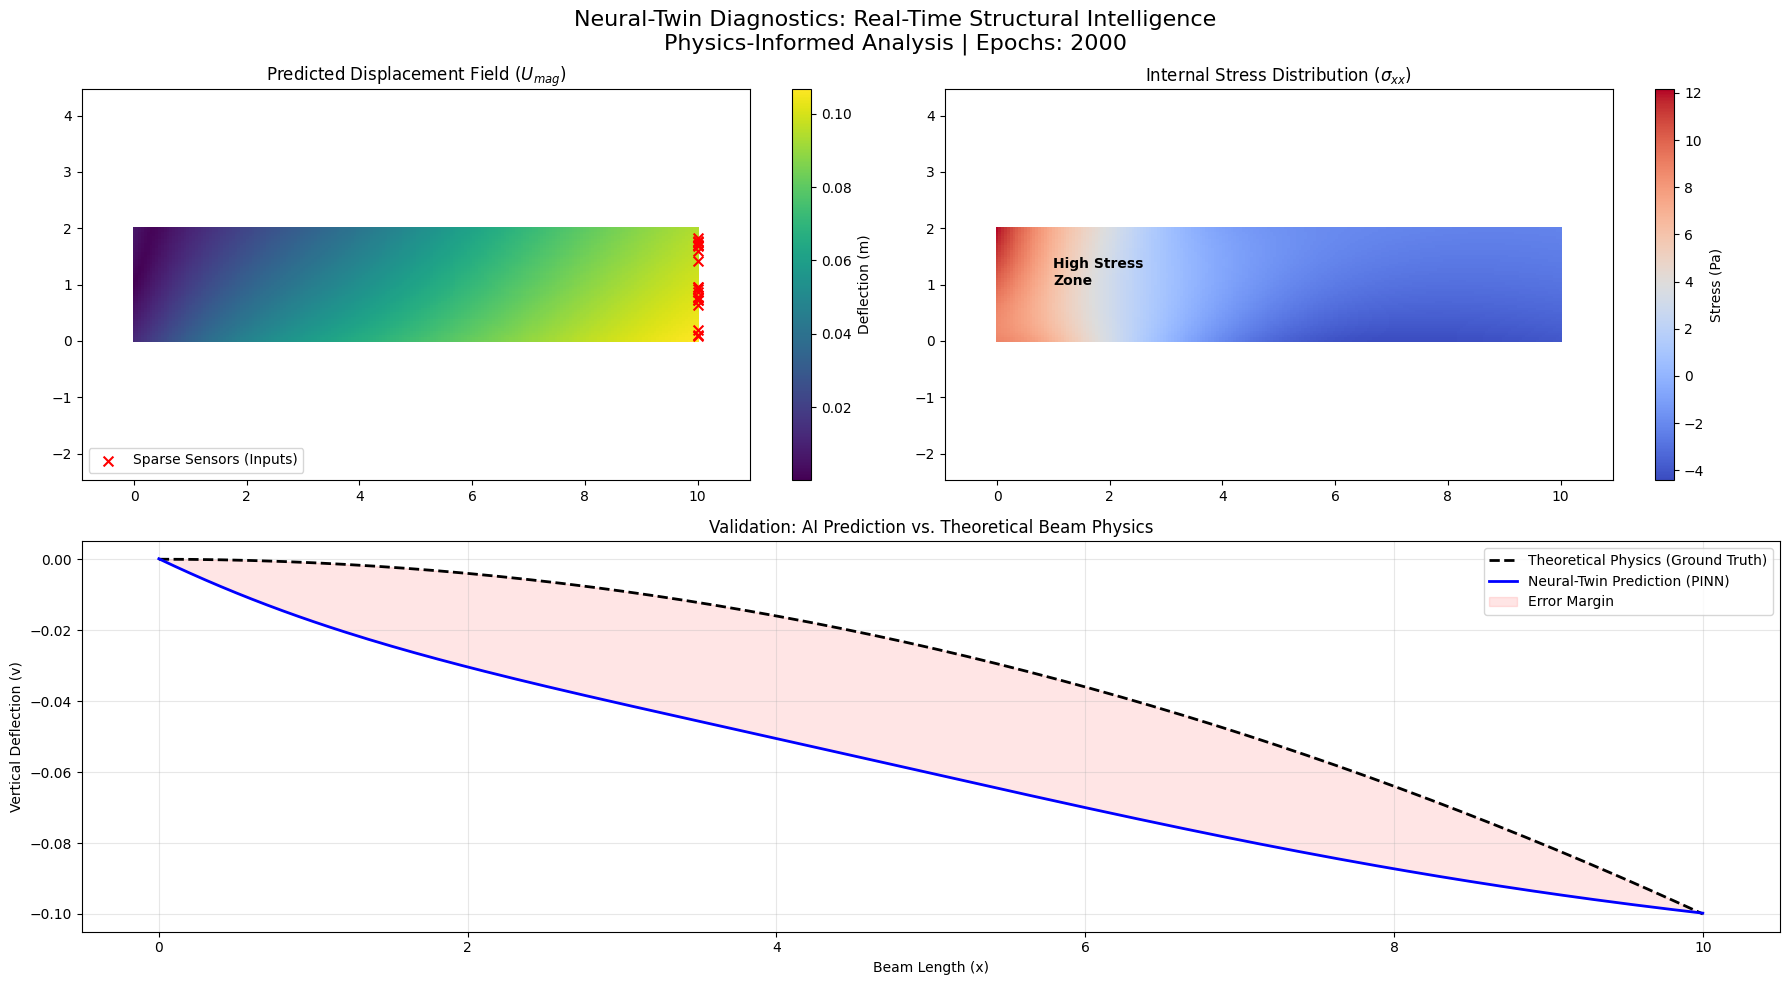

[SUCCESS] Dashboard generated and saved.


In [3]:
# ==========================================
# 6. ADVANCED VALIDATION & STRESS ANALYSIS
# ==========================================
print("\n[INFO] Generating Engineering Dashboard...")

# 1. Setup Grid with Gradient Tracking (CRITICAL FIX)
x_plot = np.linspace(0, L, 200)
y_plot = np.linspace(0, H, 50)
X, Y = np.meshgrid(x_plot, y_plot)
X_grid = np.vstack([X.flatten(), Y.flatten()]).T

# FIX: Add .requires_grad_(True) so we can compute stress later
X_grid_torch = torch.tensor(X_grid, dtype=torch.float32).to(device).requires_grad_(True)

# 2. Predict Displacements
pred = model(X_grid_torch)
u_pred = pred[:, 0].cpu().detach().numpy().reshape(X.shape)
v_pred = pred[:, 1].cpu().detach().numpy().reshape(X.shape)
displacement_mag = np.sqrt(u_pred**2 + v_pred**2)

# 3. Compute Stress Field (sigma_xx)
# We need to compute gradients of u with respect to x
u = pred[:, 0].sum() # Sum to create a scalar for autograd
u_grads = torch.autograd.grad(u, X_grid_torch, create_graph=False)[0]
# Extract du/dx (strain)
strain_xx = u_grads[:, 0].cpu().numpy().reshape(X.shape)
# Calculate Stress (Sigma = E * Strain)
stress_xx = E * strain_xx 

# ==========================================
# 7. DASHBOARD PLOTTING
# ==========================================
def analytical_solution(x):
    return -0.1 * (x / L)**2

fig = plt.figure(figsize=(18, 10))
plt.suptitle(f"Neural-Twin Diagnostics: Real-Time Structural Intelligence\nPhysics-Informed Analysis | Epochs: {epochs}", fontsize=16)

# --- PANEL 1: Displacement Field (The "Digital Twin") ---
ax1 = plt.subplot(2, 2, 1)
ax1.set_title("Predicted Displacement Field ($U_{mag}$)", fontsize=12)
c1 = ax1.pcolormesh(X, Y, displacement_mag, cmap='viridis', shading='auto')
plt.colorbar(c1, ax=ax1, label='Deflection (m)')
# Overlay Sensor Locations
ax1.scatter(x_tip, y_tip, c='red', s=50, marker='x', label='Sparse Sensors (Inputs)')
ax1.legend(loc='lower left')
ax1.axis('equal')

# --- PANEL 2: Stress Concentration (The "Failure Predictor") ---
ax2 = plt.subplot(2, 2, 2)
ax2.set_title("Internal Stress Distribution ($\sigma_{xx}$)", fontsize=12)
c2 = ax2.pcolormesh(X, Y, stress_xx, cmap='coolwarm', shading='auto')
plt.colorbar(c2, ax=ax2, label='Stress (Pa)')
ax2.text(1, H/2, "High Stress\nZone", color='black', fontsize=10, fontweight='bold')
ax2.axis('equal')

# --- PANEL 3: Validation (PINN vs Theory) ---
ax3 = plt.subplot(2, 1, 2)
ax3.set_title("Validation: AI Prediction vs. Theoretical Beam Physics", fontsize=12)

mid_index = Y.shape[0] // 2
x_line = X[mid_index, :]
v_line_pred = v_pred[mid_index, :]
v_line_true = analytical_solution(x_line)

ax3.plot(x_line, v_line_true, 'k--', linewidth=2, label='Theoretical Physics (Ground Truth)')
ax3.plot(x_line, v_line_pred, 'b-', linewidth=2, label='Neural-Twin Prediction (PINN)')
ax3.fill_between(x_line, v_line_pred, v_line_true, color='red', alpha=0.1, label='Error Margin')

ax3.set_xlabel('Beam Length (x)')
ax3.set_ylabel('Vertical Deflection (v)')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("Neural_Twin_Dashboard.png", dpi=300)
plt.show()

print("[SUCCESS] Dashboard generated and saved.")